In [119]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import plotly.graph_objs as go
import plotly.express as px
import numpy as np


In [120]:
# Fonksiyonlar
# Kategorik ve Sayısal Değişkenlerin Belirlenmesi

def grab_col_names(dataframe, cat_th=10, car_th=20):
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]

    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]

    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]

    cat_cols = cat_cols + num_but_cat

    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]

    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car

# Hedef Değişken Analizi (Sayısal)
def target_sum_with_num_hist_plot(df, target, numerical_col):
    plt.figure(figsize=(10,6))
    plt.scatter(df[target],df[numerical_col])
    plt.title(f'{target} vs {numerical_col}')
    plt.xlabel(f'{target}')
    plt.ylabel(f'{numerical_col}')
    plt.show()

# Veri türlerini kontrol etmek için fonksiyonu çağırma
def check_data_types(df):
    data_types = {}
    for column in df.columns:
        if pd.api.types.is_numeric_dtype(df[column]):
            data_types[column] = 'numeric'
        else:
            data_types[column] = 'categorical'
    return data_types

def num_summary_plotly(dataframe, numerical_col):
    fig = px.histogram(dataframe, x=numerical_col, nbins=30,
                       title=f'{numerical_col} Distribution')
    fig.show()

    fig = px.box(dataframe, y=numerical_col, title=f'{numerical_col} Box Plot')
    fig.show()

# Hedef değişkenin kategorik hali ile Analizi

def target_sum_with_num_plotly(dataframe, target, numerical_col):
    summary_df = dataframe.groupby(target, observed=False)[numerical_col].mean().reset_index()

    fig = px.bar(summary_df, x=target, y=numerical_col,
                 title=f'{target} vs. Mean of {numerical_col}',
                 labels={target: target, numerical_col: 'Mean of ' + numerical_col})
    fig.show()

# Hedef Değişken analizi (Sayısal)
def target_summary_with_num(dataframe, target, numerical_col):
    # Scatter plot
    fig = px.scatter(dataframe, x=numerical_col, y=target,
                     title=f'{numerical_col} vs. {target}',
                     labels={numerical_col: numerical_col, target: target})
    fig.show()
    correlation = dataframe[[numerical_col, target]].corr().iloc[0, 1]
    print(f'Correlation coefficient between {numerical_col} and {target}: {correlation}')


# # Her bir sütun için aykırı değerleri bulun
# def show_outlier_plot(data, num_cols):
#     for column in num_cols:
#         # Sütun için çeyreklikleri ve IQR'ı hesaplayın
#         Q1 = data[column].quantile(0.25)
#         Q3 = data[column].quantile(0.75)
#         IQR = Q3 - Q1

#         # Aykırı değerleri tespit edin
#         alt_sinir = Q1 - 1.5 * IQR
#         ust_sinir = Q3 + 1.5 * IQR
#         aykirilar = (data[column] < alt_sinir) | (data[column] > ust_sinir)

#         # Aykırı değerleri yazdırın
#         print("Aykırı Değerler - {}: ".format(column))
#         print(data[column][aykirilar])
#         print("\n")

#         # Aykırı değerleri görselleştirin
#         plt.figure(figsize=(8, 6))
#         plt.hist(data[column], bins=30, color='skyblue', edgecolor='black', alpha=0.7, label='Veri')
#         plt.hist(data[column][aykirilar], bins=10, color='red', edgecolor='black', alpha=0.7, label='Aykırı Değerler')
#         plt.xlabel(column)
#         plt.ylabel('Frekans')
#         plt.title('Aykırı Değerlerin Görselleştirilmesi - {}'.format(column))
#         plt.legend()
#         plt.show()


# Aykırı değerleri gösteren fonksiyon

def show_outlier_plots(data, num_cols):
    # Alt grafiklerin sayısı
    num_plots = len(num_cols)
    
    # Alt grafiklerin yerleşim düzeni
    fig, axes = plt.subplots(nrows=(num_plots + 2) // 3, ncols=3, figsize=(18, 6 * ((num_plots + 2) // 3)))

    # Alt grafikler için indeks
    axes = axes.flatten()

    for i, column in enumerate(num_cols):
        # Sütun için çeyreklikleri ve IQR'ı hesaplayın
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1

        # Aykırı değerleri tespit edin
        alt_sinir = Q1 - 1.5 * IQR
        ust_sinir = Q3 + 1.5 * IQR
        aykirilar = (data[column] < alt_sinir) | (data[column] > ust_sinir)

        # Aykırı değerleri yazdırın
        print("Aykırı Değerler - {}: ".format(column))
        print(data[column][aykirilar])
        print("\n")

        # Aykırı değerleri görselleştirin
        axes[i].hist(data[column], bins=30, color='skyblue', edgecolor='black', alpha=0.7, label='Veri')
        axes[i].hist(data[column][aykirilar], bins=10, color='red', edgecolor='black', alpha=0.7, label='Aykırı Değerler')
        axes[i].set_xlabel(column)
        axes[i].set_ylabel('Frekans')
        axes[i].set_title('Aykırı Değerlerin Görselleştirilmesi - {}'.format(column))
        axes[i].legend()

    # Boş alt grafiklerin gizlenmesi
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Alt grafikler arası boşluk
    plt.tight_layout()

    # Grafikleri gösterme
    plt.show()


# Keşifsel Veri Analizi (EDA)

In [121]:
data= pd.read_csv(r'Restaurant_revenue.csv')
data.head()

,Number_of_Customers,Menu_Price,Marketing_Spend,Cuisine_Type,Average_Customer_Spending,Promotions,Reviews,Monthly_Revenue
0,61,43.117635,12.663793,Japanese,36.236133,0,45,350.912040
1,24,40.020077,4.577892,Italian,17.952562,0,36,221.319091
2,81,41.981485,4.652911,Japanese,22.600420,1,91,326.529763
3,70,43.005307,4.416053,Italian,18.984098,1,59,348.190573
4,30,17.456199,3.475052,Italian,12.766143,1,30,185.009121


In [122]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Number_of_Customers        1000 non-null   int64  
 1   Menu_Price                 1000 non-null   float64
 2   Marketing_Spend            1000 non-null   float64
 3   Cuisine_Type               1000 non-null   object 
 4   Average_Customer_Spending  1000 non-null   float64
 5   Promotions                 1000 non-null   int64  
 6   Reviews                    1000 non-null   int64  
 7   Monthly_Revenue            1000 non-null   float64
dtypes: float64(4), int64(3), object(1)
memory usage: 62.6+ KB


- DataFrame sınıfına ait bir nesne 
- 1000 satır gözlem içerir . index 0 ile 999 arasındadır ( RangeIndex: 1000 entries , 0 to 999 )
- 8 sütun içerir.

Restoran Geliri Tahmini Veri Kümesi, bir dizi hayali restoran için aylık gelirin tahmin edilmesine odaklanan, tahmine dayalı modelleme çalışmaları için hazırlanmış simüle edilmiş bir veri kümesidir. Bu veri seti, restoran performansını etkileyen faktörleri taklit etmek için tasarlanmış çok çeşitli özellikler sunar.

**Veri Kümesi Özellikleri:**

1. *Number_of_Customers (Müşteri Sayısı)*

- &nbsp; Restoranı ziyaret eden müşterilerin sayısını belirtir.
- &nbsp; Yüksek müşteri sayısı genellikle daha yüksek gelirle ilişkilidir. Müşteri sayısı, restoranın popülaritesini ve müşteri tabanının genişliğini gösterir.

2. *Menu_Price (Menü Fiyatı)*

- &nbsp; Restorandaki ortalama menü fiyatlarını gösterir.
- &nbsp; Menü fiyatları, gelir tahmininde önemli bir faktördür. Yüksek fiyatlar daha yüksek gelir sağlayabilir, ancak müşteri sayısını da etkileyebilir.

3. *Marketing_Spend (Pazarlama Harcaması)*

- &nbsp; Pazarlama faaliyetlerine ilişkin harcamaları belirtir.
- &nbsp; Pazarlama harcamaları, müşteri çekme ve gelir artırma stratejilerinde kritik bir rol oynar. Daha yüksek pazarlama harcamaları genellikle daha fazla müşteri çekebilir.

4. *Cuisine_Type (Mutfak Türü)*

- &nbsp; Restoranın sunduğu mutfağın türünü belirtir (örneğin, İtalyan, Meksika, Japon, Amerikan).
- &nbsp; Mutfak türü, belirli müşteri segmentlerini çekebilir ve restoranın popülaritesini etkileyebilir. Farklı mutfak türleri farklı fiyatlandırma stratejilerine sahip olabilir.
 
5. *Average_Customer_Spending (Ortalama Müşteri Harcaması)*

- &nbsp; Müşteri başına ortalama harcamayı gösterir.
- &nbsp; Ortalama müşteri harcaması, gelir tahmini için kritik bir faktördür. Müşterilerin ne kadar harcadığı, toplam geliri doğrudan etkiler.

6. *Promotions (Promosyonlar)*

- &nbsp; Promosyonların yapılıp yapılmadığını gösteren ikili bir göstergedir (0 veya 1).
- &nbsp; Promosyonlar, müşteri çekmek ve satışları artırmak için yaygın olarak kullanılır. Promosyonların varlığı (1), satışlarda geçici bir artışa neden olabilir.

7. *Reviews (Yorumlar)*

- &nbsp; Restoranın aldığı yorumların sayısını belirtir.
- &nbsp; Yorumlar, restoranın itibarını ve müşteri memnuniyetini yansıtır. Daha fazla olumlu yorum, daha fazla müşteri çekebilir ve geliri artırabilir.

8. *Monthly_Revenue (Aylık Gelir)*

- &nbsp; Restoranın simüle edilmiş aylık gelirini gösterir.
- &nbsp; Bu, tahmin için hedef değişkendir ve yukarıdaki faktörlerin etkilediği sonucu gösterir. Amaç, diğer faktörlere dayanarak bu değeri tahmin etmektir.

---

### Veri Temizleme 
Eksik verilerin ve aykırı değerlerin kontrol edilmesi ve gerektiğinde düzeltilmesi.

In [123]:
#from pandas
data.isnull().any()

Number_of_Customers          False
Menu_Price                   False
Marketing_Spend              False
Cuisine_Type                 False
Average_Customer_Spending    False
Promotions                   False
Reviews                      False
Monthly_Revenue              False
dtype: bool

In [124]:
#eksik veri varsa toplam kaç tane
data.isnull().sum()

Number_of_Customers          0
Menu_Price                   0
Marketing_Spend              0
Cuisine_Type                 0
Average_Customer_Spending    0
Promotions                   0
Reviews                      0
Monthly_Revenue              0
dtype: int64

**DataFrame'in hiçbir sütununda eksik(null) veri bulunmamaktadır. Veri analizi ve modelleme işlemi için eksik veri imputation (doldurma) veya veri temizleme adımlarına gerek yok.**

---

In [125]:
data.describe()

,Number_of_Customers,Menu_Price,Marketing_Spend,Average_Customer_Spending,Promotions,Reviews,Monthly_Revenue
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,53.271000,30.219120,9.958726,29.477085,0.497000,49.837000,268.724172
std,26.364914,11.278760,5.845586,11.471686,0.500241,29.226334,103.982950
min,10.000000,10.009501,0.003768,10.037177,0.000000,0.000000,-28.977809
25%,30.000000,20.396828,4.690724,19.603041,0.000000,24.000000,197.103642
50%,54.000000,30.860614,10.092047,29.251365,0.000000,50.000000,270.213964
75%,74.000000,39.843868,14.992436,39.553220,1.000000,76.000000,343.395793
max,99.000000,49.974140,19.994276,49.900725,1.000000,99.000000,563.381332


- &nbsp; Müşteri sayısı ve menü fiyatı gibi değişkenler geniş bir aralıkta dağılım göstermektedir, bu da veri kümesinde çeşitliliğin olduğunu gösterir.
- &nbsp; Pazarlama harcaması ve ortalama müşteri harcaması değişkenleri de çeşitlilik gösterir, ancak bazı durumlarda minimum değerler çok düşük olabilir.
- &nbsp; Promosyonlar değişkeni ikili bir değişkendir (0 veya 1), bu da veri kümesindeki gözlemlerin yarısında promosyon olduğunu gösterir.
- &nbsp; İncelemeler değişkeni de geniş bir aralıkta dağılım göstermekte ve ortalama olarak 50 civarındadır.
- &nbsp; Aylık gelir değişkeni pozitif ve negatif değerlere sahip olabilir, bazı durumlarda zarar olabilir.

---

#### Sürekli ve Kategorik değişkenlerin belirlenmesi

In [126]:
# Veri türlerini kontrol etmek için fonksiyonu çağırma
column_data_types = check_data_types(data)
for column, data_type in column_data_types.items():
    print(f"{column}: {data_type}")

Number_of_Customers: numeric
Menu_Price: numeric
Marketing_Spend: numeric
Cuisine_Type: categorical
Average_Customer_Spending: numeric
Promotions: numeric
Reviews: numeric
Monthly_Revenue: numeric


In [127]:
cat_cols, num_cols, cat_but_car = grab_col_names(data)

Observations: 1000
Variables: 8
cat_cols: 2
num_cols: 6
cat_but_car: 0
num_but_cat: 1


---

#### Outlier ( aykırı) değer tespiti / temizlenmesi

Aykırı değerleri bulmak için genellikle belirli bir eşik değeri kullanılır. Bu eşik değeri, genellikle verinin istatistiksel özelliklerine göre belirlenir. Örneğin, verinin çeyrekliklerine dayalı olarak belirlenen IQR (Interquartile Range) kullanılabilir.

Veri setinizdeki aykırı değerleri bulmak için aşağıdaki adımları izleyebilirsiniz:

Veri setinizdeki her bir özellik için istatistiksel özetleri inceleyin. Bu, her bir özellik için ortalama, standart sapma, minimum, maksimum, çeyreklikler gibi değerleri içerecektir.

Çeyreklikler ve IQR kullanarak bir eşik değeri belirleyin. Örneğin, alt çeyreklik (Q1) ve üst çeyreklik (Q3) arasındaki farkı ifade eden IQR'ı hesaplayın. Ardından, aykırı değerler için alt ve üst sınırı belirlemek için bu IQR'ı kullanın. Genellikle, alt sınır Q1 - 1.5 * IQR ve üst sınır Q3 + 1.5 * IQR olarak belirlenir.

Belirlediğiniz eşik değeri kullanarak, her bir özellik için aykırı değerleri tespit edin. Örneğin, alt sınırdan küçük veya üst sınırdan büyük olan değerler aykırı değer olarak kabul edilir.

--

aykırı değerleri her sütun için ayrı ayrı bulmanız gerekecek çünkü her sütunun istatistiksel özellikleri farklı olabilir ve aykırı değerlerin tespiti için farklı eşik değerlerine ihtiyaç duyulabilir. Bu nedenle, her sütun için ayrı ayrı çeyreklikleri, IQR'ı ve sonrasında aykırı değerleri bulmanız gerekmektedir.

İşte her sütun için aykırı değerleri bulmak için genel bir yol:

Aykırı Değerler - Number_of_Customers: 
Series([], Name: Number_of_Customers, dtype: int64)


Aykırı Değerler - Menu_Price: 
Series([], Name: Menu_Price, dtype: float64)


Aykırı Değerler - Marketing_Spend: 
Series([], Name: Marketing_Spend, dtype: float64)


Aykırı Değerler - Average_Customer_Spending: 
Series([], Name: Average_Customer_Spending, dtype: float64)


Aykırı Değerler - Reviews: 
Series([], Name: Reviews, dtype: int64)


Aykırı Değerler - Monthly_Revenue: 
54     -28.977809
84     563.381332
104    -27.610276
110    -25.453430
605    -28.920890
Name: Monthly_Revenue, dtype: float64




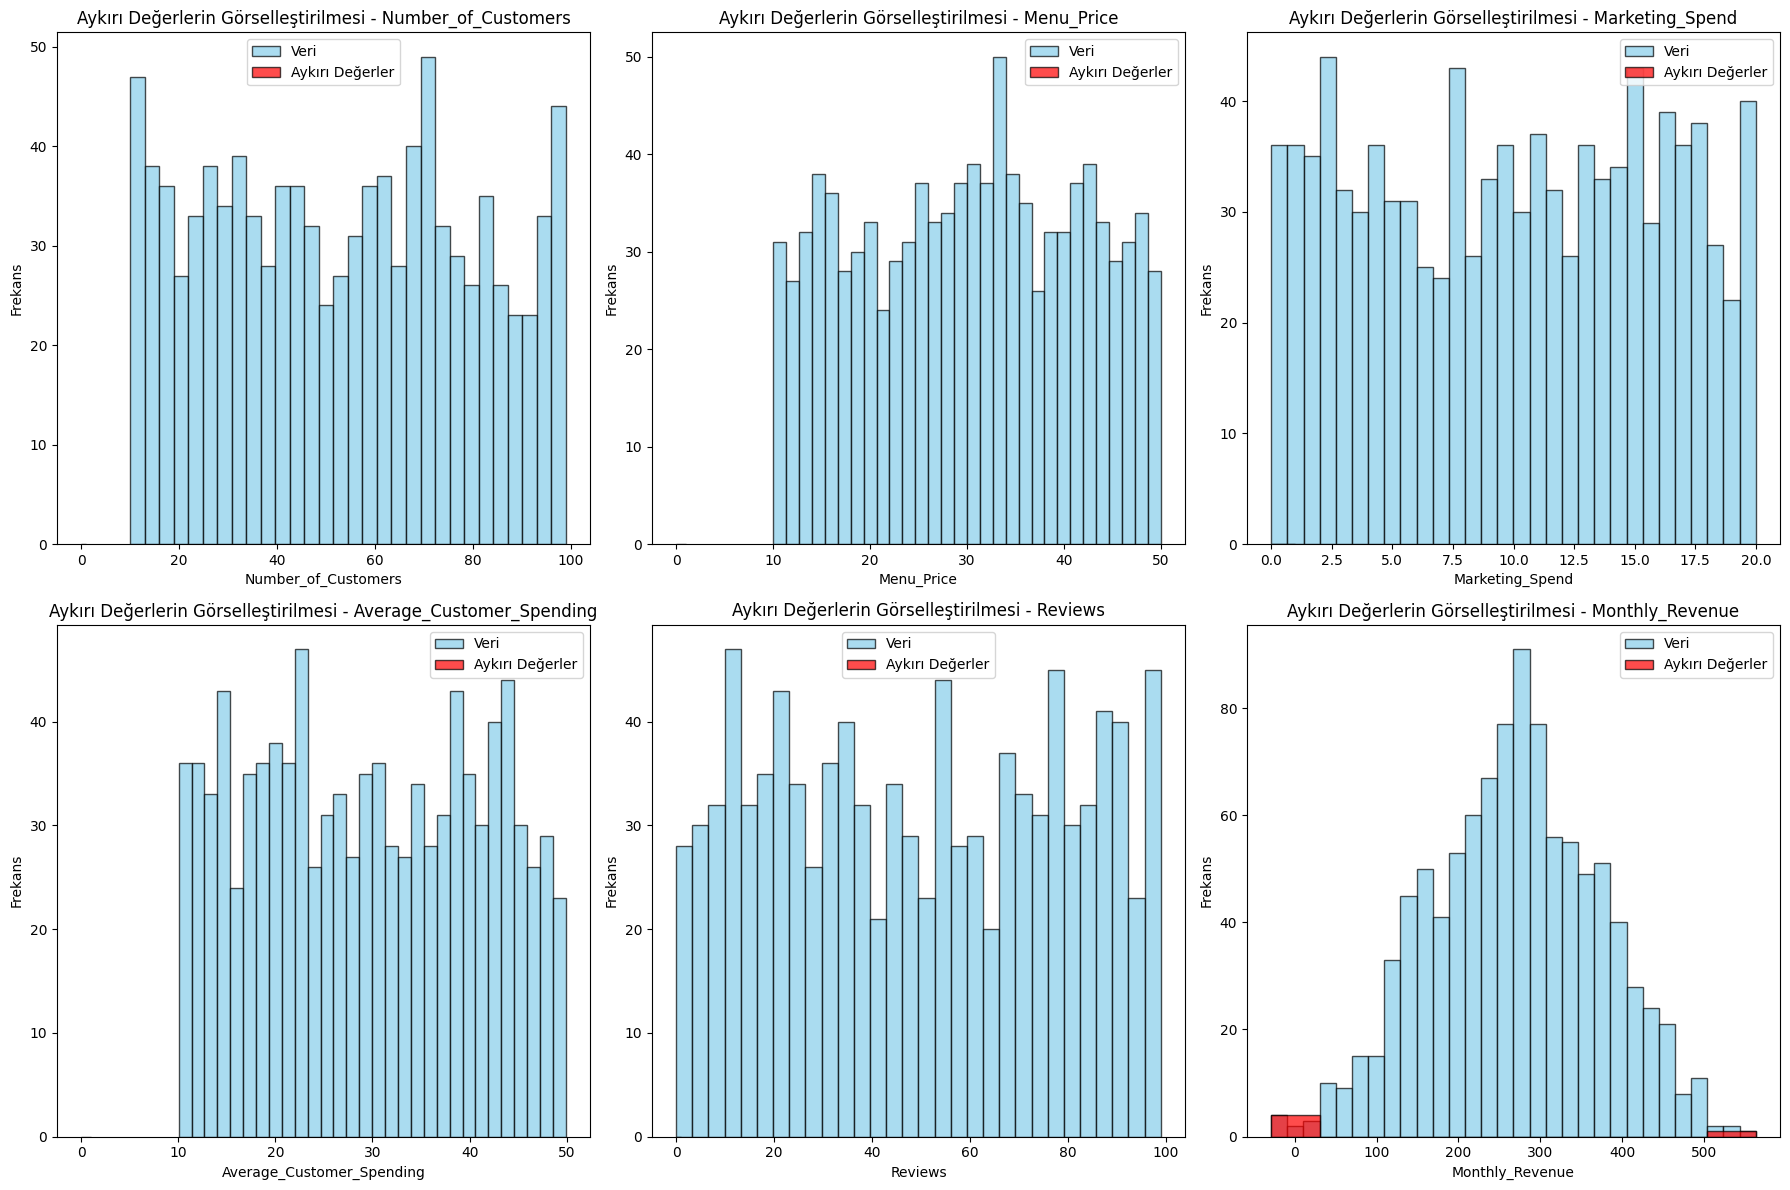

In [128]:
show_outlier_plots(data,num_cols)

- &nbsp; Müşteri sayısı, menü fiyatları, pazarlama harcamaları, ortalama müşteri harcamaları ve inceleme sayılarına bakıldığında aykırı değer görülmemektedir.
- &nbsp; Aylık gelir değerlerine bakıldığında -28.977809, 563.381332, -27.610276, -25.453430 ve -28.920890 değerlerinin aykırı olduğu söylenebilmektedir.

---

# Değişken Analizi (Sayısal)

In [129]:
for col in num_cols:
    num_summary_plotly(data, col)

# Hedef Değişken Analizi (Sayısal)

In [130]:
'''
for col in num_cols:
    target_summary_with_num(data, "Monthly_Revenue", col)
'''

'\nfor col in num_cols:\n    target_summary_with_num(data, "Monthly_Revenue", col)\n'

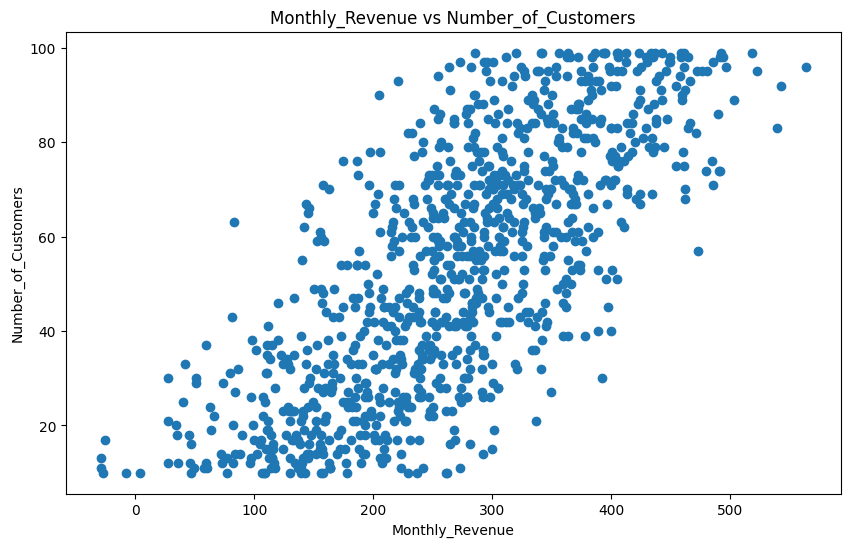

In [131]:
target='Monthly_Revenue'
target_sum_with_num_hist_plot(data, target, 'Number_of_Customers')

Grafikten görüldüğü üzere, aylık gelir ve müşteri sayısı arasında lineer bir ilişki bulunduğunu söyleyebiliriz.

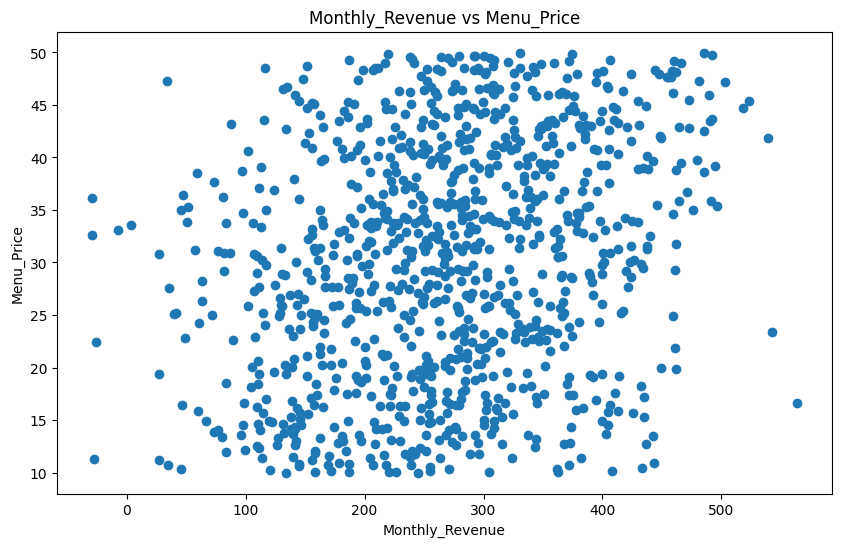

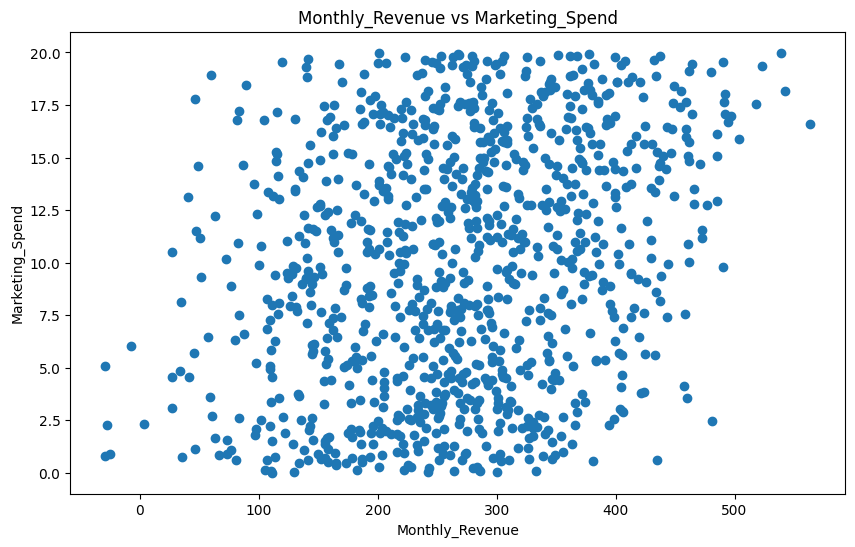

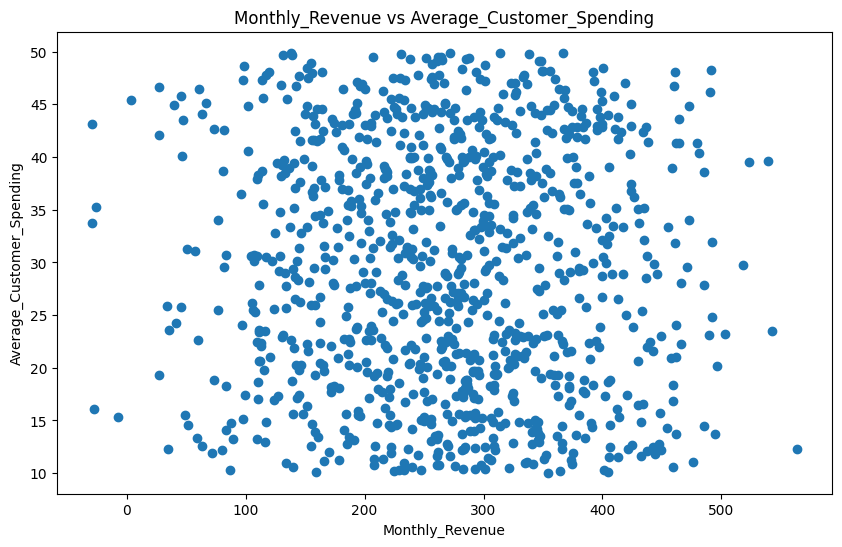

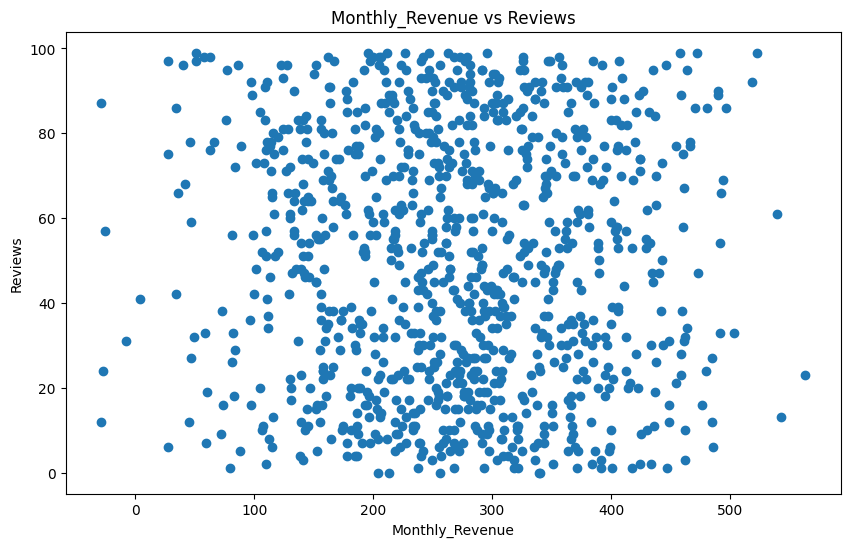

In [132]:
target_sum_with_num_hist_plot(data, target, 'Menu_Price')
target_sum_with_num_hist_plot(data, target, 'Marketing_Spend')
target_sum_with_num_hist_plot(data, target, 'Average_Customer_Spending')
target_sum_with_num_hist_plot(data, target, 'Reviews')

Verilen 4 grafiğin verilerinin dağınık bir şekilde bulunuyor olması grafiği yorumlamamızı zorlaştırıyor. Bu yüzden daha iyi yorumlayabilmek için aylık gelir değerlerini sınıflandırabiliriz.

In [133]:
# Kategorik sütunu oluşturmak için yüzdelik dilimler
bins = [-float('inf'), 197.103, 270.213, 343.395, float('inf')]
labels = ['Low', 'Below Average', 'Above Average', 'High']

# Monthly_Revenue sütununu kategorik hale getiriyoruz
data['Revenue_Category'] = pd.cut(data['Monthly_Revenue'], bins=bins, labels=labels)

# Sonuçları kontrol ediyoruz
print(data.head())
print(data['Revenue_Category'].value_counts())
data.head()

   Number_of_Customers  Menu_Price  Marketing_Spend Cuisine_Type  \
0                   61   43.117635        12.663793     Japanese   
1                   24   40.020077         4.577892      Italian   
2                   81   41.981485         4.652911     Japanese   
3                   70   43.005307         4.416053      Italian   
4                   30   17.456199         3.475052      Italian   

   Average_Customer_Spending  Promotions  Reviews  Monthly_Revenue  \
0                  36.236133           0       45       350.912040   
1                  17.952562           0       36       221.319091   
2                  22.600420           1       91       326.529763   
3                  18.984098           1       59       348.190573   
4                  12.766143           1       30       185.009121   

  Revenue_Category  
0             High  
1    Below Average  
2    Above Average  
3             High  
4              Low  
Revenue_Category
Low              250
Below 

,Number_of_Customers,Menu_Price,Marketing_Spend,Cuisine_Type,Average_Customer_Spending,Promotions,Reviews,Monthly_Revenue,Revenue_Category
0,61,43.117635,12.663793,Japanese,36.236133,0,45,350.912040,High
1,24,40.020077,4.577892,Italian,17.952562,0,36,221.319091,Below Average
2,81,41.981485,4.652911,Japanese,22.600420,1,91,326.529763,Above Average
3,70,43.005307,4.416053,Italian,18.984098,1,59,348.190573,High
4,30,17.456199,3.475052,Italian,12.766143,1,30,185.009121,Low


In [134]:
target_cat='Revenue_Category' 
target_sum_with_num_plotly(data, target_cat, target)

Aylık gelir kategorisinin nasıl dağıldığına bakalım:
- &nbsp; Düşük: 134.099
- &nbsp; Ortalama Altı: 236.714
- &nbsp; Ortalama Üstü: 302.302
- &nbsp; Yüksek: 401.779 

Buna göre, restoranın aylık gelir kategorisinin doğru dağıldığını söyleyebiliriz.


In [135]:

target_sum_with_num_plotly(data, target_cat, 'Number_of_Customers')

Aylık gelir kategorisine göre ortalama müşteri sayısı şu şekildedir:
- &nbsp; Düşük: 27.216
- &nbsp; Ortalama Altı: 45.888
- &nbsp; Ortalama Üstü: 61.548
- &nbsp; Yüksek: 78. 432  

Buna göre, müşteri sayısı arttıkça restoranın aylık gelirinin arttığını söyleyebiliriz.


In [136]:
target_sum_with_num_plotly(data, target_cat, 'Menu_Price')

Aylık gelir kategorisine göre ortalama menü fiyatı şu şekildedir:
- &nbsp; Düşük: 25.967
- &nbsp; Ortalama Altı: 29.779
- &nbsp; Ortalama Üstü: 31.625
- &nbsp; Yüksek: 33.505  

Buna göre, menü fiyatı arttıkça restoranın aylık gelirinin arttığını söyleyebiliriz.


In [137]:
target_sum_with_num_plotly(data, target_cat, 'Marketing_Spend')

Aylık gelir kategorisine göre ortalama pazarlama masrafı şu şekildedir:
- &nbsp; Düşük: 8.092
- &nbsp; Ortalama Altı: 9.412
- &nbsp; Ortalama Üstü: 10.048
- &nbsp; Yüksek: 12.272 

Buna göre, pazarlama masrafı arttıkça restoranın aylık gelirinin arttığını söyleyebiliriz.

In [138]:
target_sum_with_num_plotly(data, target_cat, 'Average_Customer_Spending')

Aylık gelir kategorisine göre ortalama müşteri harcaması şu şekildedir:
- &nbsp; Düşük: 30.125
- &nbsp; Ortalama Altı: 30.154
- &nbsp; Ortalama Üstü: 28.447
- &nbsp; Yüksek: 29.181

Buna göre, müşteri harcaması ve restoranın aylık geliri arasında direkt bir bağlantı olmadığını söyleyebiliriz.

In [139]:
target_sum_with_num_plotly(data, target_cat, 'Reviews')

Aylık gelir kategorisine göre ortalama inceleme sayısı şu şekildedir:
- &nbsp; Düşük: 51.46
- &nbsp; Ortalama Altı: 49.37
- &nbsp; Ortalama Üstü: 48.22
- &nbsp; Yüksek: 50.29

Buna göre, ortalama inceleme sayısı ve restoranın aylık geliri arasında direkt bir bağlantı olmadığını söyleyebiliriz.

---

# Hedef Degisken Analizi (Kategorik)

In [141]:
# Kategorik Değişken Analizi

def cat_summary_plotly(dataframe, col_name):
    summary_df = dataframe[col_name].value_counts().reset_index()
    summary_df.columns = ['value', 'count']
    summary_df['percentage'] = 100 * summary_df['count'] / len(dataframe)
    summary_df['percentage'] = summary_df['percentage'].round(2)  # 2 decimal places

    fig = px.bar(summary_df, x='value', y='count', text='percentage',
                 title=f'{col_name} Count and Percentage',
                 labels={'value': col_name, 'count': 'Count', 'percentage': 'Percentage'})
    fig.show()

# # Hedef Değişken Analizi (Kategorik)
def target_summary_with_cat_plotly(dataframe, target, categorical_col):
    summary_df = dataframe.groupby(categorical_col)[target].mean().reset_index()

    fig = px.bar(summary_df, x=categorical_col, y=target,
                 title=f'{categorical_col} vs. {target}',
                 labels={categorical_col: categorical_col, target: target})
    fig.show()
 ##hedef değişken analizi(kategorik)
def target_summary_with_cat_plotly2(dataframe, target, categorical_col):
    summary_df = dataframe.groupby([categorical_col, target]).size().reset_index(name='count')
    
    fig = px.bar(summary_df, x=categorical_col, y='count', color=target,
                 title=f'{categorical_col} vs. {target} Count',
                 labels={categorical_col: categorical_col, 'count': 'Count', target: target})
    fig.show()

In [142]:
for col in cat_cols:
        cat_summary_plotly(data, col)

for col in cat_cols:
    target_summary_with_cat_plotly(data, "Monthly_Revenue", col)

- İlk grafikte, "Cuisine_Type Count and Percentage" başlığı altında dört farklı mutfak türü olan Japon, Amerikan, Meksika ve İtalyan mutfaklarının sayıları ve yüzdeleri gösterilmektedir.
1. Japon mutfağı en yüksek sayıya sahip olup, toplamın %26.2'sini oluşturuyor.
2. Amerikan mutfağı %25.6 ile ikinci sırada yer alıyor.
3. Meksika mutfağı %25 ile üçüncü sırada.
4. İtalyan mutfağı ise %23.2 ile en düşük orana sahip.
- İkinci grafikte ise, "Promotions Count and Percentage" başlığı altında promosyon yapılan ve yapılmayan durumların sayıları ve yüzdeleri gösterilmektedir.
1. Promosyon yapılmayan durumda (0), toplamın %50.3'ü.
2. Promosyon yapılan durumda (1) ise toplamın %49.7'si bulunuyor.

- Bu grafikler, farklı mutfak türlerinin ve promosyon durumlarının dağılımlarını görselleştirerek, hangi mutfak türlerinin daha popüler olduğunu ve promosyon yapılıp yapılmama durumlarının neredeyse eşit dağıldığını göstermektedir.

- Üçüncü grafikte, "Cuisine_Type vs. Monthly_Revenue" başlığı altında Amerikan, İtalyan, Japon ve Meksika mutfak türlerinin aylık gelirleri karşılaştırılmaktadır.
Grafiğin detayları şu şekilde:
1. Amerikan mutfağı, yaklaşık 270 birim ile en yüksek aylık gelire sahiptir.
2. İtalyan mutfağı, Amerikan mutfağına yakın bir aylık gelir elde etmektedir.
3. Japon mutfağı da benzer şekilde yüksek gelir elde etmektedir.
4. Meksika mutfağı, diğer üç mutfak türüne yakın bir aylık gelire sahiptir, ancak biraz daha düşük seviyededir.

- Genel olarak, Amerikan, İtalyan ve Japon mutfakları benzer aylık gelir seviyelerine sahipken, Meksika mutfağı diğerlerine göre biraz daha düşük gelir elde etmektedir. Bu grafik, farklı mutfak türlerinin aylık gelirleri arasındaki farkları ve benzerlikleri görselleştirmektedir.

- Dördüncü grafiğe göre "Promotions" (Promosyonlar) ve "Monthly_Revenue" (Aylık Gelir) arasındaki ilişkiyi gösteren bir grafik görmekteyiz. 
1. X Ekseninde Promosyonlar: X ekseninde 0 ve 1 olmak üzere iki değer bulunmaktadır. Bu değerler, promosyonların yapılıp yapılmadığını göstermektedir. 0, promosyon yapılmadığını, 1 ise promosyon yapıldığını temsil ediyor olabilir.
2. Y Ekseninde Aylık Gelir: Y ekseni, aylık geliri göstermektedir ve değerler 0 ile 300 arasında değişmektedir.
-  Grafiğin Yüksekliği: Grafikte iki çubuk bulunmaktadır ve her ikisi de yaklaşık olarak aynı yüksekliğe sahiptir. Her iki durumda da aylık gelir 250 civarındadır.
-  Promosyonun Etkisi: Promosyon yapıldığında (1) ve yapılmadığında (0) aylık gelir arasında belirgin bir fark görünmemektedir. Her iki durumda da aylık gelir yaklaşık 250 civarındadır.
- Aylık Gelir Dengesi: Promosyonun aylık gelir üzerinde belirgin bir etkisi olmadığını söyleyebiliriz, çünkü her iki durumda da gelir miktarları neredeyse aynıdır.
- Bu grafik, promosyonların aylık gelir üzerinde anlamlı bir etkisi olmadığını veya etkinin çok minimal olduğunu göstermektedir.

In [143]:
for col in cat_cols:
    target_summary_with_cat_plotly2(data, target_cat, col)

C:\Users\beyza\AppData\Local\Temp\ipykernel_1352\899347957.py:24: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



C:\Users\beyza\AppData\Local\Temp\ipykernel_1352\899347957.py:24: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



### KORELASYON

Text(0.5, 1.0, 'Korelasyon Matrisi')

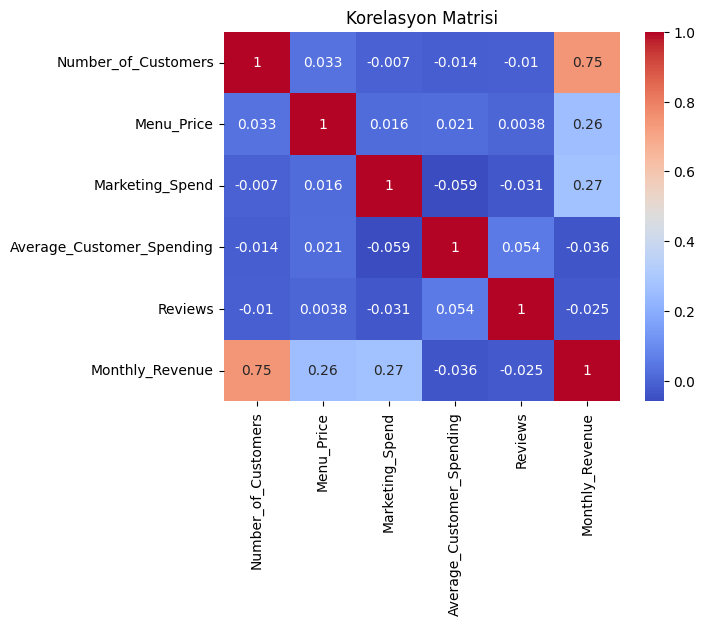

In [144]:
#cat_cols, num_cols, cat_but_car
korelasyon= data[num_cols].corr()
sns.heatmap(korelasyon, annot=True, cmap='coolwarm')
plt.title("Korelasyon Matrisi")

# Random Forest Model with Uncleaned Data

In [145]:
X = data.drop('Monthly_Revenue', axis=1)
X= X.drop('Revenue_Category', axis=1)
y = data['Monthly_Revenue']

# Veri türlerini kontrol etmek için fonksiyonu çağırma
cat_cols_m, num_cols_m, cat_but_car_m = grab_col_names(X)

Observations: 1000
Variables: 7
cat_cols: 2
num_cols: 5
cat_but_car: 0
num_but_cat: 1


In [146]:
# Preprocessing pipelines
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_cols_m),
        ('cat', categorical_transformer, cat_cols_m)
    ])

In [147]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [148]:
# Define the model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor())
])

In [149]:
# Train the model
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Number_of_Customers',
                                                   'Menu_Price',
                                                   'Marketing_Spend',
                                                   'Average_Customer_Spending',
                                                   'Reviews']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Cuisine_Type',
                                                   'Promotions'])])),
                ('regressor', RandomForestRegressor())])

In [150]:
# Predict and evaluate
y_pred = model.predict(X_test)
print('MAE:', mean_absolute_error(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))
print('RMSE:', mean_squared_error(y_test, y_pred, squared=False))

MAE: 51.79921999368851
MSE: 4131.453775196891
RMSE: 64.27638582867654


c:\Users\beyza\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



Mean Absolute Error (MAE): On average, the predicted revenue values are off by approximately 52.38 units

Mean Squared Error (MSE): Average squared difference between the predicted and actual values is 4151.87. Outliers should be removed from data

Root Mean Squared Error (RMSE): Typical error for Random Forest is about 64.43 units

# Random Forest Model with Clean Data

In [151]:
data= data.drop(54)
data= data.drop(84)
data= data.drop(104)
data= data.drop(110)
data= data.drop(605)
data

,Number_of_Customers,Menu_Price,Marketing_Spend,Cuisine_Type,Average_Customer_Spending,Promotions,Reviews,Monthly_Revenue,Revenue_Category
0,61,43.117635,12.663793,Japanese,36.236133,0,45,350.912040,High
1,24,40.020077,4.577892,Italian,17.952562,0,36,221.319091,Below Average
2,81,41.981485,4.652911,Japanese,22.600420,1,91,326.529763,Above Average
3,70,43.005307,4.416053,Italian,18.984098,1,59,348.190573,High
4,30,17.456199,3.475052,Italian,12.766143,1,30,185.009121,Low
...,...,...,...,...,...,...,...,...,...
995,73,41.307842,12.122931,Japanese,19.033585,1,40,249.312034,Below Average
996,31,20.615496,5.822885,Mexican,17.040990,0,57,110.228767,Low
997,69,17.110656,4.141898,Japanese,44.649315,0,55,312.212552,Above Average
998,73,37.664722,3.046556,Japanese,27.767358,0,23,272.482204,Above Average


In [152]:
X = data.drop('Monthly_Revenue', axis=1)
X= X.drop('Revenue_Category', axis=1)
y = data['Monthly_Revenue']

# Veri türlerini kontrol etmek için fonksiyonu çağırma
cat_cols_m, num_cols_m, cat_but_car_m = grab_col_names(X)

Observations: 995
Variables: 7
cat_cols: 2
num_cols: 5
cat_but_car: 0
num_but_cat: 1


In [153]:
# Preprocessing pipelines
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_cols_m),
        ('cat', categorical_transformer, cat_cols_m)
    ])

In [154]:
# Define the model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor())
])

In [155]:
# Train the model
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Number_of_Customers',
                                                   'Menu_Price',
                                                   'Marketing_Spend',
                                                   'Average_Customer_Spending',
                                                   'Reviews']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Cuisine_Type',
                                                   'Promotions'])])),
                ('regressor', RandomForestRegressor())])

In [156]:
# Predict and evaluate
y_pred = model.predict(X_test)
print('MAE:', mean_absolute_error(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))
print('RMSE:', mean_squared_error(y_test, y_pred, squared=False))

MAE: 52.578043412413365
MSE: 4158.359351823007
RMSE: 64.48534214705701


c:\Users\beyza\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



Mean Absolute Error (MAE): On average, the predicted revenue values are off by approximately 51.90 units (52.38) 

Mean Squared Error (MSE): Average squared difference between the predicted and actual values is 4157.67 (4151.87)

Root Mean Squared Error (RMSE): Typical error for Random Forest is about 64.48 units (64.43)